In [1]:
pwd()

"/Users/kyan/Projects/qgplsim"

# Start

In [4]:
# run this ceil if source codes was edited
include("DGP.ji")
# include("qgplsim.ji")
include("MonteCarloSIM.ji")
using Statistics, LinearAlgebra, Clustering
using LaTeXStrings, Plots

import Base.Threads.@threads

# QGPLSIM fitting

In [8]:
# run this ceil for different data sets

α = [1.0, 2.0] # single index for x
θ = [2.0, -1.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 1.0] # single index for z
β = [-1.0, -0.5] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)

n = 400
fx = 2 # y = f(x), fx for different f(x)     
                # fx = 1, y = X*θ + Z*β + (X*α + Z*γ .- 1).^2 + 0.2ϵ
                # fx = 2, y = X*θ + Z*β + log.(1 .+ exp.(X*α + Z*γ .- 1)) + 0.2ϵ

ifz = true # if false, Z = 0, i.e. no category varible
dist = 1 # 0 for gauss, 1 for Cauchy
X, Z, y = dgp(n, γ, θ, α, β, fx, dist,  ifz)
# p = length(α)
# q = length(γ)
τ = 0.5

# Estimation 

model1 = qgplsim.model(X, Z, y, τ)
alpha_type = 1
# different weight of sum on alpha 
# 0 for true alpha, using α in DGP
# 1 for global: ∑ij sum(Bi - Bj) / n;
# 2 for local: ∑z ∑ij (bzi - bzj) * nz / n;
# when Z = 0, global == local
@time alpha1, gamma, theta, beta, squ = qgplsim.estimator(model1, alpha_type)
coefa = 1 #/ alpha[1]
coefg = 1 #/ gamma[1]
println("Estimation of index coefs: ")
println("̂α => ", coefa * alpha1)
println("̂γ => ", gamma)

println("Estimation of linear coefs: ")
println("̂θ => ", theta)
println("̂β => ", beta)

println("square of integral: ", squ)

# theta * alpha

c1 - c0: 0.9107524613923325
v1 - v0: 3.648140329543253
  0.959135 seconds (2.05 M allocations: 6.241 GiB, 22.78% gc time)
Estimation of index coefs: 
̂α => [0.4066771210569237; 0.9135719562294216]
̂γ => [0.15867659898375286, 0.372354178795599]
Estimation of linear coefs: 
̂θ => [2.0598008871861913 -0.9169216382349368]
̂β => [-0.43130098502273456, 0.017123223850836283]
square of integral: 3.3225527846361524


# Paths of $g(x \alpha + z \gamma)$ and $\nabla g$

$\alpha = \hat{\alpha}$,
$z \in S_z$

In [48]:
model1.index

Dict{Vector{Float64}, Vector{Int64}} with 6 entries:
  [0.0, 1.0]  => [4, 14, 28, 30, 48, 58, 59, 82, 85, 89  …  437, 444, 459, 471,…
  [1.0, 0.0]  => [10, 17, 18, 20, 21, 23, 33, 34, 36, 39  …  458, 461, 462, 463…
  [1.0, -1.0] => [5, 12, 13, 24, 51, 54, 55, 56, 68, 70  …  420, 441, 442, 447,…
  [0.0, -1.0] => [3, 9, 22, 27, 37, 47, 66, 71, 81, 94  …  419, 424, 426, 439, …
  [1.0, 1.0]  => [2, 6, 7, 29, 32, 40, 42, 46, 53, 64  …  438, 445, 457, 460, 4…
  [0.0, 0.0]  => [1, 8, 11, 15, 16, 19, 25, 26, 31, 35  …  454, 456, 464, 467, …

In [49]:
g = zeros(n)
dg = zeros(n)
v = X * alpha1 
yz = y - X * transpose(theta)
categ, index = model1.categ, model1.index
z = collect(index)
ncateg = index.count
width = zeros(ncateg)
v0 = -1e6
v1 = 1e6

for k in 1:ncateg
    vk = v[z[k][2]]
    h = (length(vk))^(-0.17) * var(vk)
    width[k] = h

    dgk(u) = qgplsim.Gz(u, vk, yz[z[k][2]], 1, τ)
    gk(u) = qgplsim.Gz(u, vk, yz[z[k][2]], 0, τ)

    dg[z[k][2]] = dgk(vk)
    g[z[k][2]] = gk(vk)

    vkmin = minimum(vk) + h
    vkmax = maximum(vk) - h

    if  vkmin > v0
        v0 = vkmin
    end
    if  vkmax < v1
        v1 = vkmax
    end  
end

# g, dg = qgplsim.G(v, Z, yz, τ, -0.4) # g: g(v), dg: g'(v)

println(width)
# v0, v1 = v0 + h, v1 - h
v0, v1

[0.9961516529344712, 1.1633100429450591, 1.0705221254852395, 1.4043335308722025, 1.2881943607885207, 0.8879106385479579]


(-2.9850278518471587, 1.0274044004154943)

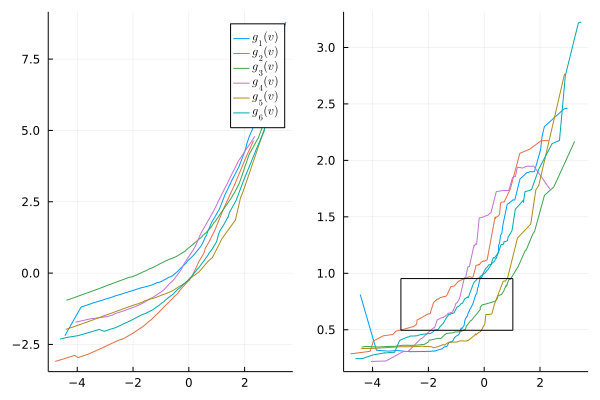

In [50]:
C0 = zeros(ncateg)
C1 = zeros(ncateg)
dgf(vv, k) = qgplsim.Gz(vv, v[z[k][2]], yz[z[k][2]], 1, τ)


p1 = plot()
p2 = plot()
for m in 1:ncateg
    C0[m] = dgf(v0, m)[1]
    C1[m] = dgf(v1, m)[1]

    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]
    plot!(p1, sorted_vm, sorted_gm, label = L"g_{%$m} (v)")
    plot!(p2, sorted_vm, sorted_dgm, label = false )# L"\nabla g_{%$m} (v)")

end

c0 = maximum(C0)
c1 = minimum(C1)
plot!(p2, [v0, v0], [c0, c1], color = "black", label = false)
plot!(p2, [v1, v1], [c0, c1], color = "black", label = false)
plot!(p2, [v0, v1], [c0, c0], color = "black", label = false)
plot!(p2, [v0, v1], [c1, c1], color = "black", label = false)


plot(p1, p2, layout = (1,2))

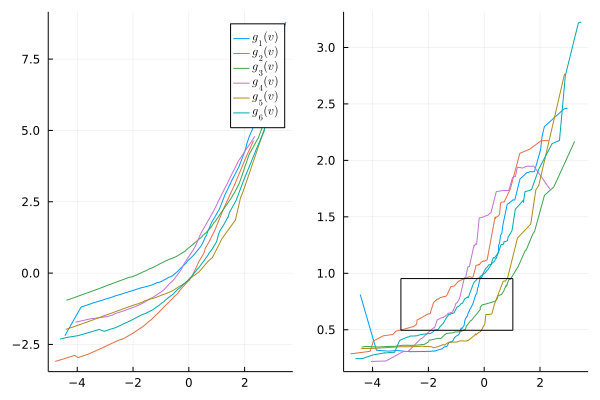

In [53]:
C0 = zeros(ncateg)
C1 = zeros(ncateg)
dgf(vv, k) = qgplsim.Gz(vv, v[z[k][2]], yz[z[k][2]], 1, τ)


p1 = plot()
p2 = plot()
for m in 1:ncateg
    C0[m] = dgf(v0, m)[1]
    C1[m] = dgf(v1, m)[1]

    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]
    plot!(p1, sorted_vm, sorted_gm, label = L"g_{%$m} (v)")
    plot!(p2, sorted_vm, sorted_dgm, label = false )# L"\nabla g_{%$m} (v)")

end

c0 = maximum(C0)
c1 = minimum(C1)
plot!(p2, [v0, v0], [c0, c1], color = "black", label = false)
plot!(p2, [v1, v1], [c0, c1], color = "black", label = false)
plot!(p2, [v0, v1], [c0, c0], color = "black", label = false)
plot!(p2, [v0, v1], [c1, c1], color = "black", label = false)


plot(p1, p2, layout = (1,2))

In [173]:
[C0 C1]

4×2 Matrix{Float64}:
 -0.020623   2.20933
  0.0952253  2.07785
 -0.116579   2.32559
 -0.106289   1.94253

# Monte Carlo Simulation

In [9]:
Threads.nthreads()

2

In [10]:
include("MonteCarloSIM.ji")

main (generic function with 4 methods)

In [11]:
α = [1.0, 0.5] # single index for x
θ = [0.5, -1.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 1.0] # single index for z
β = [-1.0, -0.5] # linear for z
τ = 0.5
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n = 200
fx = 2
dist = 1 # Cauchy
rep = 200 # MC rept. times

200

In [ ]:
Alpha, Gamma, Theta, Beta, Squ = MonteCarlo(n, γ, θ, α, β, τ, fx, dist, rep)

c1 - c0: 0.09829502223909514
v1 - v0: 3.461906783319572
c1 - c0: 0.004914326683644665
v1 - v0: 3.983773435129378


In [ ]:
mb = mean(Beta, dims = 1)

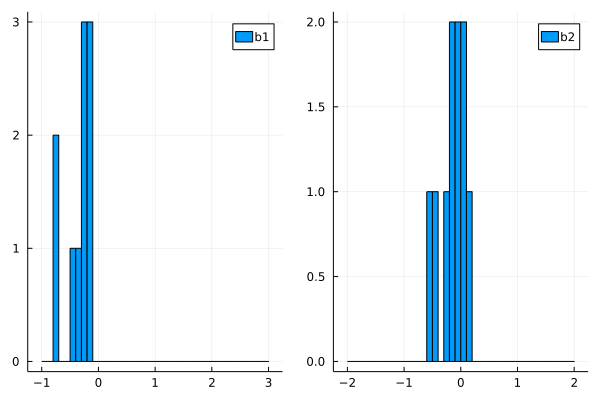

In [11]:

p1 = histogram(Beta[:,1], bins = -1:0.1:3, label = "b1")
p2 = histogram(Beta[:,2], bins = -2:0.1:2, label = "b2")
plot(p1, p2, layout = (1, 2))

In [14]:
mg = mean(Gamma, dims = 1)

1×2 Matrix{Float64}:
 0.255734  0.470576

In [197]:
(γ |> transpose) ./ mg

1×2 Matrix{Float64}:
 2.13107  2.21011

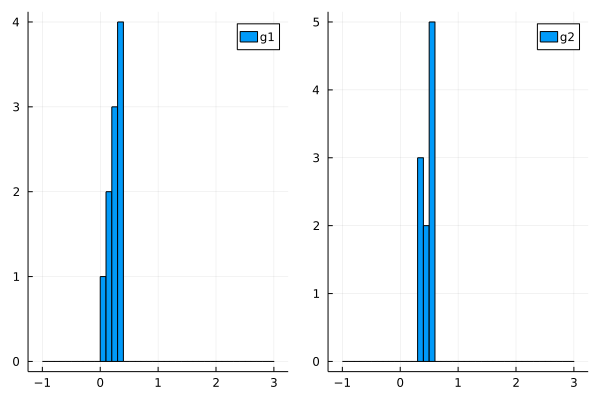

In [13]:
p1 = histogram(Gamma[:,1], bins = -1:0.1:3, label = "g1")
p2 = histogram(Gamma[:,2], bins = -1:0.1:3, label = "g2")
plot(p1, p2, layout = (1, 2))

In [157]:
ma = mean(Alpha, dims = 1)

1×2 Matrix{Float64}:
 0.878183  0.451094

In [158]:
mt = mean(Theta, dims = 1)

1×2 Matrix{Float64}:
 0.511953  -0.969122

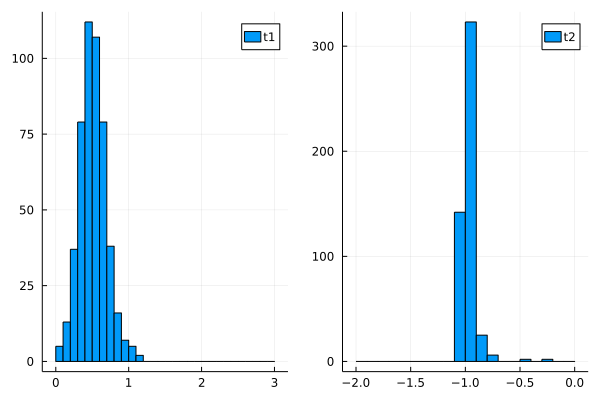

In [159]:
p1 = histogram(Theta[:,1], bins = 0:0.1:3, label = "t1")
p2 = histogram(Theta[:,2], bins = -2:0.1:-0, label = "t2")
plot(p1, p2, layout = (1, 2))

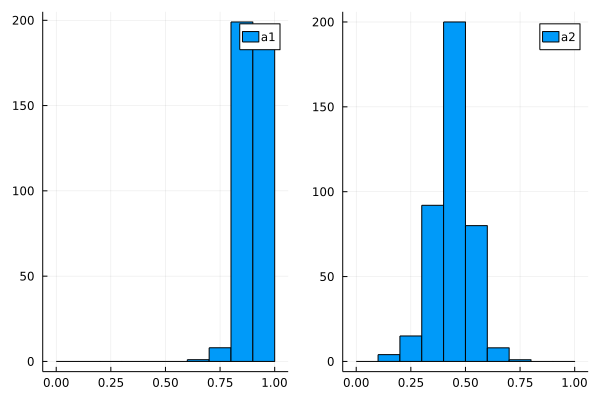

In [349]:
p1 = histogram(Alpha[:,1], bins = 0:0.1:1, label = "a1")
p2 = histogram(Alpha[:,2], bins = 0:0.1:1, label = "a2")
plot(p1, p2, layout = (1, 2))

In [373]:
mg * sqrt(5)

1×2 Matrix{Float64}:
 0.540775  1.10552